In [12]:
import ee
import xarray
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [2]:
import geopandas as gpd
gdf = gpd.read_file("aoi.geojson")

In [16]:
import rasterio
from rasterio.features import geometry_mask

def create_mask(xarray_dataset, geodataframe):
    # Convert the GeoDataFrame's geometry to a format suitable for rasterio
    geoms = [geom.__geo_interface__ for geom in geodataframe.geometry]

    # Create a mask array from the geometry
    mask = geometry_mask(geoms, out_shape=(len(xarray_dataset.lat), len(xarray_dataset.lon)),
                         transform=rasterio.transform.from_origin(xarray_dataset.lat.min(), xarray_dataset.lat.max(),
                                                                  xarray_dataset.lon[1] - xarray_dataset.lon[0],
                                                                  xarray_dataset.lat[1] - xarray_dataset.lat[0]),
                         invert=True)
    return mask

In [17]:
ds = xarray.open_dataset('COPERNICUS/S5P/OFFL/L3_NO2', engine='ee')

In [18]:
ds

<xarray.Dataset>
Dimensions:                                  (time: 29830, lon: 360, lat: 180)
Coordinates:
  * time                                     (time) datetime64[ns] 2018-06-28...
  * lon                                      (lon) float32 -179.5 ... 179.5
  * lat                                      (lat) float32 89.5 88.5 ... -89.5
Data variables:
    NO2_column_number_density                (time, lon, lat) float64 ...
    tropospheric_NO2_column_number_density   (time, lon, lat) float64 ...
    stratospheric_NO2_column_number_density  (time, lon, lat) float64 ...
    NO2_slant_column_number_density          (time, lon, lat) float64 ...
    tropopause_pressure                      (time, lon, lat) float64 ...
    absorbing_aerosol_index                  (time, lon, lat) float64 ...
    cloud_fraction                           (time, lon, lat) float64 ...
    sensor_altitude                          (time, lon, lat) float64 ...
    sensor_azimuth_angle                     (time, lon, lat) float64 ...
    sensor_zenith_angle                      (time, lon, lat) float64 ...
    solar_azimuth_angle                      (time, lon, lat) float64 ...
    solar_zenith_angle                       (time, lon, lat) float64 ...
Attributes: (12/19)
    date_range:               [1530144000000, 1647129600000]
    description:              <h3 id="offll3_no2">OFFL/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [19]:
# Generate the mask
mask = create_mask(ds, gdf)

In [20]:
# Apply the mask
subset_ds = ds.where(mask, drop=True)

TypeError: cond argument is array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]) but must be a <class 'xarray.core.dataset.Dataset'> or <class 'xarray.core.dataarray.DataArray'>

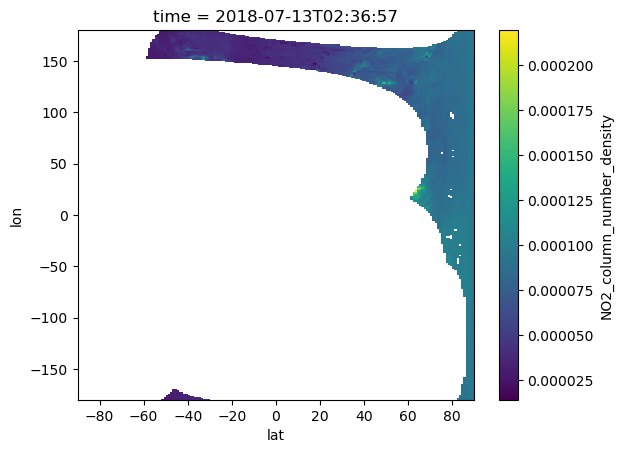

In [6]:
ds.isel(time=200).NO2_column_number_density.plot()

In [21]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr

In [22]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [34]:
longitude = 79.109
latitude = 22.746


geometry = {
    "type": "Polygon",
    "coordinates": [
            [
              [
                102.36882852420172,
                52.4855297099906
              ],
              [
                135.16797056252193,
                52.4855297099906
              ],
              [
                135.16797056252193,
                67.43936927138265
              ],
              [
                102.36882852420172,
                67.43936927138265
              ],
              [
                102.36882852420172,
                52.4855297099906
              ]
            ]
  ],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "no2"}},
)
items = list(search.get_items())

print(f"Found {len(items)} items:")

/home/prasad/.local/lib/python3.10/site-packages/pystac_client/item_search.py:831: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found 16 items:


In [35]:
f = fsspec.open(items[0].assets["no2"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                                               (scanline: 4172,
                                                           ground_pixel: 450,
                                                           time: 1, corner: 4,
                                                           polynomial_exponents: 6,
                                                           intensity_offset_polynomial_exponents: 1,
                                                           layer: 34,
                                                           vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...

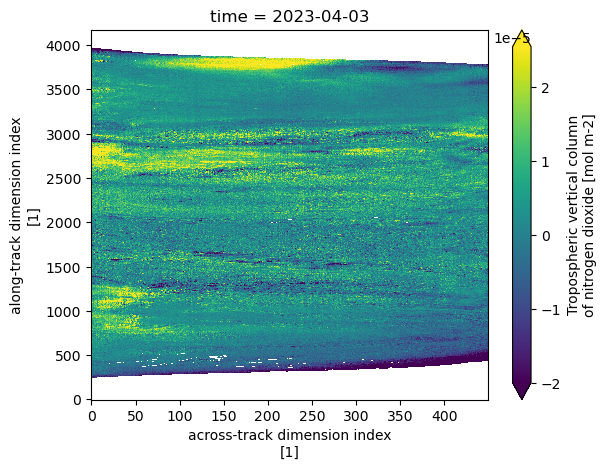

In [36]:
varname = "nitrogendioxide_tropospheric_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="viridis");

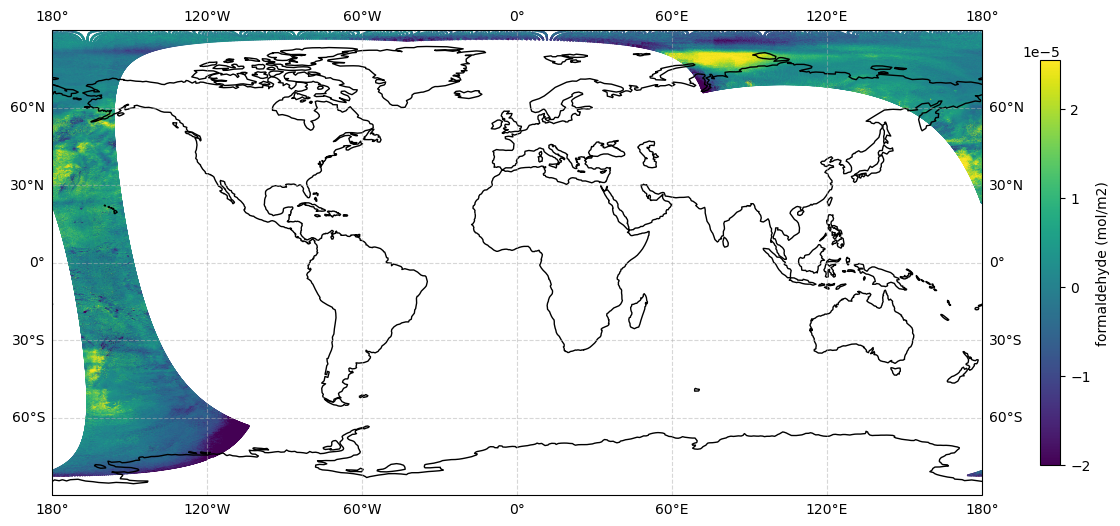

In [37]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

In [39]:
import requests
import os
import datetime
from dateutil.relativedelta import relativedelta

def download_s3_files(bucket_url, time_period, start_date, end_date):
    # Convert the input dates to datetime objects
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    if end_date <= start_date:
        raise ValueError("End date must be greater than the start date.")

    # Date formatting for file naming based on the time period
    date_format = {
        'daily': "%Y%m%d",
        'monthly': "%Y%m",
        'yearly': "%Y"
    }[time_period]

    # Folder to store downloaded files
    download_folder = f"downloaded_{time_period}_files"
    os.makedirs(download_folder, exist_ok=True)

    current_date = start_date
    while current_date < end_date:
        formatted_date = current_date.strftime(date_format)
        file_name = f"S5P_OFFL_L3_NO2_{time_period}composite_{formatted_date}.nc.gz"  # Example file naming pattern
        file_url = f"{bucket_url}/{file_name}"

        response = requests.get(file_url)
        if response.status_code == 200:
            file_path = os.path.join(download_folder, file_name)
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {file_path}")
        else:
            print(f"Failed to download {file_name} - Status code: {response.status_code}")

        # Increment date
        if time_period == 'daily':
            current_date += datetime.timedelta(days=1)
        elif time_period == 'monthly':
            current_date += relativedelta(months=1)
        elif time_period == 'yearly':
            current_date += relativedelta(years=1)

    print("Finished downloading files.")

# Usage
bucket_url = "https://tropomi-no2-l3.data.lit.fmi.fi"
download_s3_files(bucket_url, 'daily', '2020-06-01', '2020-07-01')

Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200601.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200602.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200603.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200604.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200605.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200606.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200607.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200608.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200609.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200610.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200611.nc.gz
Downloaded downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200612.nc.gz
Downloaded downloaded_daily_files/S5P_OF

In [10]:
ds = xr.open_dataset("downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200601.nc")

In [4]:
import gzip
import shutil
import os

def decompress_gz_files(directory):
    # List all files in the directory and decompress if they end with .gz
    for filename in os.listdir(directory):
        if filename.endswith('.gz'):
            gz_path = os.path.join(directory, filename)
            nc_path = gz_path[:-3]  # Remove the '.gz' from the filename to get the .nc filename
            with gzip.open(gz_path, 'rb') as f_in:
                with open(nc_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(gz_path)  # Optionally remove the .gz file after extraction
            print(f"Decompressed {gz_path} to {nc_path}")

# Example usage
directory = 'downloaded_daily_files'
decompress_gz_files(directory)

Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200605.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200605.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200608.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200608.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200618.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200618.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200604.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200604.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200610.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200610.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200629.nc.gz to downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200629.nc
Decompressed downloaded_daily_files/S5P_OFFL_L3_NO2_dailycomposite_20200609.nc.gz to downloade

In [13]:
import geopandas as gpd

# Load GeoJSON file
geo_df = gpd.read_file('aoi.geojson')

In [16]:
import xarray as xr
import rioxarray
import pandas as pd
from shapely.geometry import mapping

def preprocess_and_subset(file_path, geo_df):
    # Open the dataset
    ds = xr.open_dataset(file_path)
    ds = ds.rio.write_crs("epsg:4326")  # Ensure the dataset's CRS is set (adjust if necessary)
    
    # Clip the dataset using the GeoJSON boundary
    clipped = ds.rio.clip(geo_df.geometry.apply(mapping), geo_df.crs, drop=True)
    
    # Extract the date from the filename and set it as the time coordinate
    date_str = file_path.split('_')[-1][:8]  # Adjust indexing based on your filename format
    date = pd.to_datetime(date_str, format='%Y%m%d')
    
    # Check if 'time' dimension needs adjusting
    if 'time' in clipped.dims:
        clipped['time'] = [date]  # Replace existing 'time' coordinate with the new one
    else:
        clipped = clipped.assign_coords(time=date).expand_dims('time')
    
    return clipped

In [17]:
import os

def concatenate_datasets(directory, geo_df):
    # Find all NetCDF files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nc')]
    datasets = []
    
    for file in files:
        try:
            dataset = preprocess_and_subset(file, geo_df)
            datasets.append(dataset)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Concatenate all datasets along the time dimension
    if datasets:
        combined_ds = xr.concat(datasets, dim='time')
        return combined_ds
    else:
        return None

# Example usage
directory = 'downloaded_daily_files'
geojson_file = 'aoi.geojson'
geo_df = gpd.read_file(geojson_file)
combined_dataset = concatenate_datasets(directory, geo_df)
print(combined_dataset)

<xarray.Dataset>
Dimensions:                                             (time: 30,
                                                         latitude: 299,
                                                         longitude: 656)
Coordinates:
    spatial_ref                                         int64 0
  * latitude                                            (latitude) float32 52...
  * longitude                                           (longitude) float32 1...
  * time                                                (time) datetime64[ns] ...
Data variables:
    datetime_start                                      (time) datetime64[ns] ...
    tropospheric_NO2_column_number_density              (time, latitude, longitude) float64 ...
    tropospheric_NO2_column_number_density_uncertainty  (time, latitude, longitude) float64 ...
    datetime_stop                                       (time) datetime64[ns] ...
    count                                               (time) int32 9853453 .

In [20]:
combined_dataset

<xarray.Dataset>
Dimensions:                                             (time: 30,
                                                         latitude: 299,
                                                         longitude: 656)
Coordinates:
    spatial_ref                                         int64 0
  * latitude                                            (latitude) float32 52...
  * longitude                                           (longitude) float32 1...
  * time                                                (time) datetime64[ns] ...
Data variables:
    datetime_start                                      (time) datetime64[ns] ...
    tropospheric_NO2_column_number_density              (time, latitude, longitude) float64 ...
    tropospheric_NO2_column_number_density_uncertainty  (time, latitude, longitude) float64 ...
    datetime_stop                                       (time) datetime64[ns] ...
    count                                               (time) int32 9853453 ...
    weight                                              (time, latitude, longitude) float32 ...
Attributes:
    Conventions:        HARP-1.0
    datetime_start:     7463.0210271875
    datetime_stop:      7464.036359988426
    history:            2023-11-03T23:09:30Z [harp-1.18] harp.import_product(...
    data_provider:      Finnish Meteorological Institute
    data_origin:        Copernicus Sentinel-5P/TROPOMI
    legal_notice:       Contains modified Copernicus Sentinel data processed ...
    processor_version:  2.4.0

In [22]:
combined_dataset.to_netcdf('combined_no2_data_1.nc')

In [29]:
combined_dataset = combined_dataset.sortby('time')
combined_dataset.to_netcdf('combined_no2_data_1.nc')

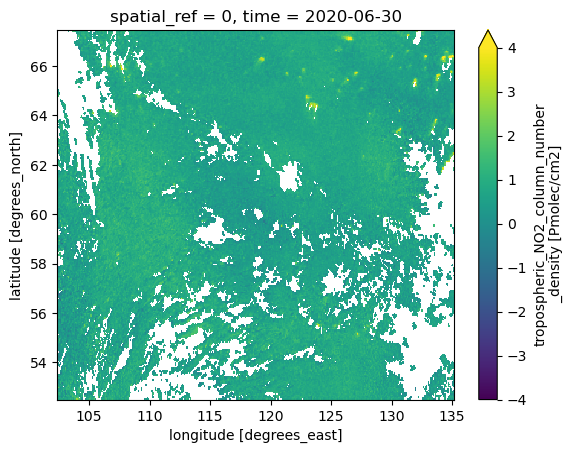

In [28]:
combined_dataset.isel(time=29).tropospheric_NO2_column_number_density.plot(vmin=-4, vmax=4, cmap='viridis')